In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import re

from tqdm import tqdm
import time

import pydicom as dicom
import nibabel as nib
import SimpleITK as sitk
import monai

import torch
import torch.nn as nn
import torch.optim as optim

from monai.networks.nets import EfficientNetBN
from monai.networks.nets import ResNet
#from efficientnet_pytorch import EfficientNet
import timm

import wandb


In [2]:
SEED = 344
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Fix the network according to random seed
    print('Finish seeding with seed {}'.format(seed))
    
seed_everything(SEED)
print('Training on device {}'.format(device))

Finish seeding with seed 344
Training on device cuda


In [3]:
dicom_tag_columns = [
    'Columns',
    'ImageOrientationPatient',
    'ImagePositionPatient',
    'InstanceNumber',
    'PatientID',
    'PatientPosition',
    'PixelSpacing',
    'RescaleIntercept',
    'RescaleSlope',
    'Rows',
    'SeriesNumber',
    'SliceThickness',
    'path',
    'WindowCenter',
    'WindowWidth'
]

train_dicom_tags = pd.read_parquet('autodl-tmp/train_dicom_tags.parquet', columns=dicom_tag_columns)
test_dicom_tags = pd.read_parquet('autodl-tmp/test_dicom_tags.parquet', columns=dicom_tag_columns)

train_series_meta = pd.read_csv('autodl-tmp/train_series_meta.csv')
test_series_meta = pd.read_csv('autodl-tmp/test_series_meta.csv')

train_csv = pd.read_csv('autodl-tmp/train.csv')

mid_z_csv = pd.read_csv('middle_z.csv')
complete_series_meta = mid_z_csv[mid_z_csv.middle_z != -1].reset_index()
complete_series_meta

,index,patient_id,series_id,middle_z
0,0,10004,21057,128
1,1,10004,51033,131
2,2,10005,18667,120
3,3,10007,47578,127
4,4,10026,29700,110
...,...,...,...,...
4392,4393,9961,2003,133
4393,4394,9961,63032,129
4394,4395,9980,40214,94
4395,4396,9980,40466,151


In [4]:
def raw_path_gen(patient_id, series_id, train=True):
    if(train):
        path = 'autodl-tmp/train_images_resample/'
    else:
        path = 'autodl-tmp/train_images_resample/'
    
    path += str(patient_id) + '/' + str(series_id)
    
    return path

def create_3D_scans(folder, downsample_rate=1): 
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]
        
    volume = []
    #for filename in tqdm(filenames[::downsample_rate], position=0): 
    for filename in filenames[::downsample_rate]: 
        filepath = os.path.join(folder, filename)
        ds = dicom.dcmread(filepath)
        image = ds.pixel_array
        
        if ds.PixelRepresentation == 1:
            bit_shift = ds.BitsAllocated - ds.BitsStored
            dtype = image.dtype 
            image = (image << bit_shift).astype(dtype) >>  bit_shift
        
        # find rescale params
        if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
            intercept = float(ds.RescaleIntercept)
            slope = float(ds.RescaleSlope)
    
        # find clipping params
        center = int(ds.WindowCenter)
        width = int(ds.WindowWidth)
        low = center - width / 2
        high = center + width / 2    
        
        
        image = (image * slope) + intercept
        image = np.clip(image, low, high)

        image = (image / np.max(image) * 255).astype(np.int16)
        image = image[::downsample_rate, ::downsample_rate]
        volume.append( image )
    
    volume = np.stack(volume, axis=0)
    return volume

def plot_image_with_seg(volume, volume_seg=[], orientation='Coronal', num_subplots=20):
    # simply copy
    if len(volume_seg) == 0:
        plot_mask = 0
    else:
        plot_mask = 1
        
    if orientation == 'Coronal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([1, 0, 2])
        if plot_mask:
            volume_seg = volume_seg.transpose([1, 0, 2])
        
    elif orientation == 'Sagittal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([2, 0, 1])
        if plot_mask:
            volume_seg = volume_seg.transpose([2, 0, 1])

    elif orientation == 'Axial':
        slices = np.linspace(0, volume.shape[0]-1, num_subplots).astype(np.int16)
           
    rows = np.max( [np.floor(np.sqrt(num_subplots)).astype(int) - 2, 1])
    cols = np.ceil(num_subplots/rows).astype(int)
    
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 2, rows * 4))
    fig.tight_layout(h_pad=0.01, w_pad=0)
    
    ax = ax.ravel()
    for this_ax in ax:
        this_ax.axis('off')

    for counter, this_slice in enumerate( slices ):
        plt.sca(ax[counter])
        
        image = volume[this_slice, :, :]
        plt.imshow(image, cmap='gray')
        
        if plot_mask:
            mask = np.where(volume_seg[this_slice, :, :], volume_seg[this_slice, :, :], np.nan)
            plt.imshow(mask, cmap='Set1', alpha=0.5)
            
def load_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/'):
    path = root + str(patient_id) + '/' + str(series_id) + '.nii.gz'
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    
    # img = nib.load(path)
    # img = img.get_fdata().transpose(2, 1, 0)
    
    return img

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

ds = 2

midz_pd = pd.read_csv('middle_z.csv')

class CTDataset(Dataset):
    def __init__(self, root='autodl-tmp/train_images_resample/', augmentation=False, meta=train_series_meta, device='cpu'):
        self.device = device
        self.series_meta = meta
        self.root = root
        self.t = monai.transforms.Compose([monai.transforms.RandZoom(prob=0.5, min_zoom=0.9, max_zoom=1.1),
                                           monai.transforms.RandRotate(range_x=3.14 / 24, prob=0.5),
                                           monai.transforms.SpatialPad(spatial_size=(320//ds, 280, 280), mode="edge"),
                                           monai.transforms.RandSpatialCrop(roi_size=(320//ds, 256, 256), random_size=False),
                                           monai.transforms.NormalizeIntensity(divisor = 400)
                                ])
        self.t_val = monai.transforms.Compose([monai.transforms.NormalizeIntensity(divisor = 400)])
        
        self.aug = augmentation
        
    def __len__(self):
        #return 1100
        return len(self.series_meta)
    
    def __getitem__(self, idx):

        patient_id, series_id = self.series_meta.loc[idx, ["patient_id", "series_id"]].astype('int')
        middle_z = midz_pd.loc[midz_pd.series_id == series_id, "middle_z"].values[0] // ds
        
        img_a = load_nii(patient_id, series_id, self.root).astype('float32')
        #img_t = torch.from_numpy(img_a).unsqueeze(0)
        #img_t = torch.from_numpy(img_a[::2, ::2, ::2]).unsqueeze(0)
        if(self.aug):
            img_t = self.t(np.expand_dims(img_a[::ds, :, :], 0))
        else:
            #img_t = torch.from_numpy(img_a[::ds, ::ds, ::ds]).unsqueeze(0)
            img_t = self.t_val(np.expand_dims(img_a[::ds, :, :], 0))
        label_columns = [
            'kidney_low',
            'kidney_high',
            'liver_low',
            'liver_high',
            'spleen_low',
            'spleen_high',
            #'any_injury'
        ]
        label_a = train_csv.loc[train_csv.patient_id == patient_id, label_columns].values[0].astype('float32')
        label_t = torch.from_numpy(label_a)
        label_midz = torch.tensor(middle_z.astype('int'))
        
        return img_t, label_t, label_midz

In [6]:
# class EffNet(nn.Module):
#     def __init__(self, ch_out=9):
#         super(EffNet, self).__init__()
#         #self.conv_in = nn.Conv3d(1, 3, kernel_size=5, padding=2, stride=2)
#         self.net = EfficientNetBN("efficientnet-b0", pretrained=False, progress=False, spatial_dims=3, in_channels=1, num_classes=ch_out,)
#     def forward(self, x):
#         #x = self.conv_in(x)
#         #return torch.sigmoid(self.net(x))
#         return self.net(x)

class KLSVolNet(nn.Module):
    def __init__(self, backbone = "tf_efficientnetv2_s.in21k_ft_in1k", 
                 ch_in = 3, ch_out = 9, slices = 15, dropout = 0.0, pretrained=True):
        super(KLSVolNet, self).__init__()
        self.slices = slices
        
        self.encoder = timm.create_model(
            backbone,
            in_chans=ch_in,
            num_classes=ch_out,
            features_only=False,
            drop_rate=0.0,
            drop_path_rate=0.0,
            pretrained=False,
        )
        
        if 'efficient' in backbone and pretrained:
            self.encoder.load_state_dict(torch.load('pretrained/tf_efficientnetv2_s.in21k_ft_in1k_6class.pt'))
        elif 'convnext' in backbone and pretrained:
            self.encoder.load_state_dict(torch.load('pretrained/convnextv2_nano.fcmae_ft_in22k_in1k_384_6class.pt'))
        
        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()
        
        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=0.0, bidirectional=True, batch_first=True)
        
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.LeakyReLU(0.1),
            nn.Linear(256, ch_out),
        )
        
        self.head2 = nn.Conv1d(slices, 1, 1)
        
        
    def slicer(self, img, mid_z, slices):
        img_kls = []
        for i in range(0, len(mid_z)):
            z = mid_z[i]
            if z < 30:
                z = 30
            elif img.shape[-3] - z < 30:
                z = img.shape[-3] - 31
                
            slice_kls = img[i, :, z-30:z+30, :, :]
            img_kls.append(slice_kls)
            # plot_image_with_seg(slice_kls[0].numpy(), orientation='Axial', num_subplots=7)
        img = torch.cat(img_kls, 0)
        img = img.unsqueeze(1)
        #print(img.shape)
        z_length = img.shape[-3]
        z_slices = (np.linspace(0, z_length, slices + 2)).astype('int')
        z_slices = z_slices[1:-1]
        #print(z_slices)
        slices_list = []
        for z in z_slices:
            slices_list.append(img[:, :, z-1:z+2, :, :])
        img_slice = torch.cat(slices_list, 1)
        return img_slice
        
    def forward(self, x, mid_z):  # (bs, nslice, ch, sz, sz)
        x = self.slicer(x, mid_z, self.slices)
        bs, nslice,ch, sz1, sz2 = x.shape
        x = x.view(bs*nslice, ch, sz1, sz2)
        
        feature_2d = self.encoder(x)
        feature_2d = feature_2d.view(bs, nslice, -1)
        
        feature_lstm, _ = self.lstm(feature_2d)
        feature_lstm = feature_lstm.contiguous().view(bs * nslice, -1)
        
        preds = self.head(feature_lstm)
        preds = preds.view(bs, nslice, -1).contiguous()
        preds = self.head2(preds)
        
        return preds.squeeze(1)
        
        
        # bs = x.shape[0]
        # x = x.view(bs * n_slice_per_c, in_chans, image_size, image_size)
        # feat = self.encoder(x)
        # feat = feat.view(bs, n_slice_per_c, -1)
        # feat, _ = self.lstm(feat)
        # feat = feat.contiguous().view(bs * n_slice_per_c, -1)
        # feat = self.head(feat)
        # feat = feat.view(bs, n_slice_per_c).contiguous()
        

In [7]:
import sklearn.metrics

def transform_9class(label_in):
    label_out = [1 - label_in[0],
                   label_in[0],
                    1- label_in[1],
                   label_in[1],
                   (1 - label_in[2]) * (1 - label_in[3]),
                   label_in[2],
                   label_in[3],
                   (1 - label_in[4]) * (1 - label_in[5]),
                    label_in[4],
                   label_in[5],
                   (1 - label_in[6]) * (1 - label_in[7]),
                   label_in[6],
                   label_in[7]]
    return label_out

def transform_13class(label_in):
    label_out = label_in
    return label_out.tolist()

def transform_kls9class(label_in):
    label_out = [1, 1, 1, 1]
    label_out.extend(label_in.tolist())
    return label_out

def transform_kls6class(label_in):
    label_kls = label_in
    label_in = [0.5, 0.5]
    label_in.extend(label_kls.tolist())
    label_out = [1, 1, 1, 1,
                   (1 - label_in[2]) * (1 - label_in[3]),
                   label_in[2],
                   label_in[3],
                   (1 - label_in[4]) * (1 - label_in[5]),
                    label_in[4],
                   label_in[5],
                   (1 - label_in[6]) * (1 - label_in[7]),
                   label_in[6],
                   label_in[7]]
    return label_out


def loss_metrics(metrics, transform):
    preds = [transform(x) for x in metrics["predict"]]
    targets = [transform(x) for x in metrics["label"]]
    targets_any_injury = metrics["label"][:, -1]
    
    loss_list = []
    
    print("F1 score: ", sklearn.metrics.f1_score(metrics["label"], np.around(metrics["predict"]), average=None, zero_division=0.0))
    print("AUC score: ", sklearn.metrics.roc_auc_score(metrics["label"], metrics["predict"], average=None))
    # print("AUC score after transform: ", sklearn.metrics.roc_auc_score(targets, preds, average=None))
    
    
    for i in range(0, len(preds)):
        predict = preds[i]
        target = targets[i]
        
        label_pred = np.zeros(14)
        label_pred[0] = predict[0] / (predict[0] + predict[1])
        label_pred[1] = predict[1] / (predict[0] + predict[1])
        label_pred[2] = predict[2] / (predict[2] + predict[3])
        label_pred[3] = predict[3] / (predict[2] + predict[3])
        label_pred[4] = predict[4] / (predict[4] + predict[5] + predict[6])
        label_pred[5] = predict[5] / (predict[4] + predict[5] + predict[6])
        label_pred[6] = predict[6] / (predict[4] + predict[5] + predict[6])
        label_pred[7] = predict[7] / (predict[7] + predict[8] + predict[9])
        label_pred[8] = predict[8] / (predict[7] + predict[8] + predict[9])
        label_pred[9] = predict[9] / (predict[7] + predict[8] + predict[9])
        label_pred[10] = predict[10] / (predict[10] + predict[11] + predict[12])
        label_pred[11] = predict[11] / (predict[10] + predict[11] + predict[12])
        label_pred[12] = predict[12] / (predict[10] + predict[11] + predict[12])
        label_pred[13] = max([1 - label_pred[x] for x in [0, 2, 4, 7, 10]])
        
        targets_any_injury = max([1 - target[x] for x in [0, 2, 4, 7, 10]])
        
        target.append(targets_any_injury)
        label_target = np.array(target)
        
        weight = np.array([1, 2, 1, 6, 1, 2, 4, 1, 2, 4, 1, 2, 4, 6])
        
        loss_list.append(sklearn.metrics.log_loss(
            y_true=label_target,
            y_pred=label_pred,
            sample_weight=weight))
    #print("Weighted Loss: " + np.mean(loss_list))
    
    return np.mean(loss_list)
        
    
    
    #print(np.array(preds).shape)
    

In [8]:
val_df_fold1 = complete_series_meta[0:1100].reset_index(drop=True)
val_df_fold2 = complete_series_meta[1100:2200].reset_index(drop=True)
val_df_fold3 = complete_series_meta[2200:3300].reset_index(drop=True)
val_df_fold4 = complete_series_meta[3300:].reset_index(drop=True)

val_ds_fold1 = CTDataset(meta = val_df_fold1, augmentation=False)
val_dl_fold1 = DataLoader(val_ds_fold1, batch_size=4, shuffle=False, num_workers=8)
val_ds_fold2 = CTDataset(meta = val_df_fold2, augmentation=False)
val_dl_fold2 = DataLoader(val_ds_fold2, batch_size=4, shuffle=False, num_workers=8)
val_ds_fold3 = CTDataset(meta = val_df_fold3, augmentation=False)
val_dl_fold3 = DataLoader(val_ds_fold3, batch_size=4, shuffle=False, num_workers=8)
val_ds_fold4 = CTDataset(meta = val_df_fold4, augmentation=False)
val_dl_fold4 = DataLoader(val_ds_fold4, batch_size=4, shuffle=False, num_workers=8)

val_dl_list = [val_dl_fold1, val_dl_fold2, val_dl_fold3, val_dl_fold4]

weight_effnet = ['KLS2.5D-nophase-4fold/KLS2.5D-nophase_Effnetv2_4fold/fold1.pt',
                'KLS2.5D-nophase-4fold/KLS2.5D-nophase_Effnetv2_4fold/fold2.pt',
                'KLS2.5D-nophase-4fold/KLS2.5D-nophase_Effnetv2_4fold/fold3.pt',
                'KLS2.5D-nophase-4fold/KLS2.5D-nophase_Effnetv2_4fold/fold4.pt']

weight_effnetx2 = ['KLS2.5Dx2-nophase-4fold/KLS2.5Dx2-nophase_Effnetv2_4fold/fold1.pt',
                  'KLS2.5Dx2-nophase-4fold/KLS2.5Dx2-nophase_Effnetv2_4fold/fold2.pt',
                  'KLS2.5Dx2-nophase-4fold/KLS2.5Dx2-nophase_Effnetv2_4fold/fold3.pt',
                  'KLS2.5Dx2-nophase-4fold/KLS2.5Dx2-nophase_Effnetv2_4fold/fold4.pt']

weight_convnext = ['KLS2.5D-nophase-4fold/KLS2.5D-nophase_Convnetv2_4fold/fold1.pt',
                  'KLS2.5D-nophase-4fold/KLS2.5D-nophase_Convnetv2_4fold/fold2.pt',
                  'KLS2.5D-nophase-4fold/KLS2.5D-nophase_Convnetv2_4fold/fold3.pt',
                  'KLS2.5D-nophase-4fold/KLS2.5D-nophase_Convnetv2_4fold/fold4.pt']

weight_convnextx2 = ['KLS2.5Dx2-nophase-4fold/KLS2.5Dx2-nophase_Convnetv2_4fold/fold1.pt',
                    'KLS2.5Dx2-nophase-4fold/KLS2.5Dx2-nophase_Convnetv2_4fold/fold2.pt',
                    'KLS2.5Dx2-nophase-4fold/KLS2.5Dx2-nophase_Convnetv2_4fold/fold3.pt',
                    'KLS2.5Dx2-nophase-4fold/KLS2.5Dx2-nophase_Convnetv2_4fold/fold4.pt']

In [9]:
# autodl-tmp/fullvol_outputs

In [10]:
kls_columns = ['kidney_low',
                'kidney_high',
                'liver_low',
                'liver_high',
                'spleen_low',
                'spleen_high',]

kls_effnet = pd.DataFrame(columns=kls_columns)
kls_effnetx2 = pd.DataFrame(columns=kls_columns)
kls_convnext = pd.DataFrame(columns=kls_columns)
kls_convnextx2 = pd.DataFrame(columns=kls_columns)
kls_labels = pd.DataFrame(columns=kls_columns)
kls_convnextx2

,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high


In [11]:
metrics_effnet = {'predict': [], 'label' : []}
metrics_effnetx2 = {'predict': [], 'label' : []}
metrics_convnext = {'predict': [], 'label' : []}
metrics_convnextx2 = {'predict': [], 'label' : []}

for i in range(0, 4):
    
    val_dl = val_dl_list[i]
    for imgs, labels, midz in tqdm(val_dl):
        imgs = imgs.to(device)
        labels = labels.to(device)
        midz = midz.to(device)
        # effnet
        backbone = "tf_efficientnetv2_s.in21k_ft_in1k"
        model = KLSVolNet(backbone=backbone, ch_out = 6, pretrained=False).to(device)
        model.load_state_dict(torch.load(weight_effnet[i]))
        model.eval()
        with torch.no_grad():
            outputs = model(imgs[:, :, :, ::2, ::2], midz)
            #outputs = model(imgs.unsqueeze(1))
            outputs = torch.sigmoid(outputs)
            metrics_effnet['predict'].extend((outputs.to('cpu').detach().numpy()).tolist())
            metrics_effnet['label'].extend((labels.to('cpu').detach().numpy()).tolist())
            
        # convnext
        backbone = 'convnextv2_nano.fcmae_ft_in22k_in1k_384'
        model = KLSVolNet(backbone=backbone, ch_out = 6, pretrained=False).to(device)
        model.load_state_dict(torch.load(weight_convnext[i]))
        model.eval()
        with torch.no_grad():
            outputs = model(imgs[:, :, :, ::2, ::2], midz)
            #outputs = model(imgs.unsqueeze(1))
            outputs = torch.sigmoid(outputs)
            metrics_convnext['predict'].extend((outputs.to('cpu').detach().numpy()).tolist())
            metrics_convnext['label'].extend((labels.to('cpu').detach().numpy()).tolist())
        
        # effnetx2
        backbone = "tf_efficientnetv2_s.in21k_ft_in1k"
        model = KLSVolNet(backbone=backbone, ch_out = 6, pretrained=False).to(device)
        model.load_state_dict(torch.load(weight_effnetx2[i]))
        model.eval()
        with torch.no_grad():
            outputs = model(imgs, midz)
            #outputs = model(imgs.unsqueeze(1))
            outputs = torch.sigmoid(outputs)
            metrics_effnetx2['predict'].extend((outputs.to('cpu').detach().numpy()).tolist())
            metrics_effnetx2['label'].extend((labels.to('cpu').detach().numpy()).tolist())
            
        # convnextx2
        backbone = 'convnextv2_nano.fcmae_ft_in22k_in1k_384'
        model = KLSVolNet(backbone=backbone, ch_out = 6, pretrained=False).to(device)
        model.load_state_dict(torch.load(weight_convnextx2[i]))
        model.eval()
        with torch.no_grad():
            outputs = model(imgs, midz)
            #outputs = model(imgs.unsqueeze(1))
            outputs = torch.sigmoid(outputs)
            metrics_convnextx2['predict'].extend((outputs.to('cpu').detach().numpy()).tolist())
            metrics_convnextx2['label'].extend((labels.to('cpu').detach().numpy()).tolist())
    
#     metrics_effnet['predict'] = np.array(metrics_effnet['predict'])
#     metrics_effnet['label'] = np.array(metrics_effnet['label'])
#     weighted_loss = loss_metrics(metrics_effnet, transform_9class)
    
#     metrics_effnetx2['predict'] = np.array(metrics_effnetx2['predict'])
#     metrics_effnetx2['label'] = np.array(metrics_effnetx2['label'])
#     weighted_loss = loss_metrics(metrics_effnetx2, transform_9class)

 #    [0.73890339 0.72617573 0.69875816 0.86453416 0.68637631 0.7738663369  0.67781067 0.82793679]
 #    [0.77554695 0.7308704  0.73534463 0.83195652 0.73175591 0.8018366841  0.68756256 0.8529517 ]

100%|██████████| 275/275 [10:53<00:00,  2.38s/it]


In [29]:
kls_labels = pd.DataFrame(data = metrics_convnextx2['label'], columns=kls_columns)
kls_labels

,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high
0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
4392,0.0,0.0,0.0,0.0,0.0,0.0
4393,0.0,0.0,0.0,0.0,0.0,0.0
4394,0.0,0.0,0.0,0.0,0.0,1.0
4395,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
# kls_labels.to_csv('autodl-tmp/kls_outputs/kls_labels.csv', index=None)

In [14]:
kls_effnet = pd.DataFrame(data = metrics_effnet['predict'], columns=kls_columns)
kls_effnet

,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high
0,0.263335,0.038007,0.169457,0.091786,0.305354,0.068963
1,0.697941,0.127877,0.332818,0.090328,0.590730,0.149592
2,0.182179,0.346120,0.077847,0.029259,0.273330,0.590014
3,0.051106,0.041930,0.023441,0.008730,0.034941,0.022737
4,0.267900,0.095260,0.748070,0.064021,0.292641,0.115150
...,...,...,...,...,...,...
4392,0.361374,0.193415,0.511244,0.100253,0.244847,0.070965
4393,0.418956,0.146054,0.314437,0.073380,0.226350,0.091164
4394,0.589334,0.594164,0.457466,0.186274,0.776149,0.770756
4395,0.637064,0.554129,0.315331,0.148123,0.694966,0.633310


In [26]:
# kls_effnet.to_csv('autodl-tmp/kls_outputs/kls_effnet.csv', index=None)

In [16]:
kls_effnetx2 = pd.DataFrame(data = metrics_effnetx2['predict'], columns=kls_columns)
kls_effnetx2

,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high
0,0.370531,0.055604,0.140607,0.037490,0.092234,0.096739
1,0.447954,0.095495,0.293350,0.069776,0.161746,0.196853
2,0.055988,0.207769,0.039430,0.015219,0.064288,0.134257
3,0.078104,0.062517,0.019504,0.033102,0.014811,0.057417
4,0.027593,0.019177,0.097176,0.088710,0.160325,0.070162
...,...,...,...,...,...,...
4392,0.339240,0.314310,0.504836,0.099192,0.411440,0.146684
4393,0.517979,0.346885,0.439708,0.093734,0.410701,0.168885
4394,0.512056,0.676303,0.819610,0.247327,0.651858,0.514456
4395,0.677848,0.770058,0.760391,0.350089,0.619768,0.690042


In [30]:
# kls_effnetx2.to_csv('autodl-tmp/kls_outputs/kls_effnetx2.csv', index=None)

In [18]:
kls_convnext = pd.DataFrame(data = metrics_convnext['predict'], columns=kls_columns)
kls_convnext

,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high
0,0.357706,0.116401,0.315497,0.089736,0.506236,0.679511
1,0.352021,0.140301,0.384444,0.071323,0.590214,0.733146
2,0.069000,0.147491,0.022457,0.029242,0.109829,0.143380
3,0.070969,0.107408,0.105975,0.028841,0.333644,0.406352
4,0.105718,0.027712,0.059102,0.035818,0.042773,0.031765
...,...,...,...,...,...,...
4392,0.267424,0.429451,0.558925,0.301336,0.578241,0.325275
4393,0.251771,0.473968,0.552874,0.368800,0.523585,0.232205
4394,0.542047,0.195798,0.251711,0.202071,0.714626,0.884494
4395,0.622107,0.307484,0.323120,0.256582,0.774773,0.960278


In [31]:
# kls_convnext.to_csv('autodl-tmp/kls_outputs/kls_convnext.csv', index=None)

In [20]:
kls_convnextx2 = pd.DataFrame(data = metrics_convnextx2['predict'], columns=kls_columns)
kls_convnextx2

,kidney_low,kidney_high,liver_low,liver_high,spleen_low,spleen_high
0,0.182627,0.043527,0.075215,0.063764,0.084621,0.098589
1,0.166694,0.080089,0.085787,0.102016,0.122700,0.174540
2,0.008780,0.021215,0.036151,0.012352,0.056553,0.026400
3,0.079860,0.055317,0.035989,0.033064,0.106598,0.094461
4,0.395113,0.219579,0.216677,0.248852,0.125579,0.110472
...,...,...,...,...,...,...
4392,0.156246,0.275065,0.395611,0.103744,0.300648,0.160195
4393,0.126584,0.231537,0.294042,0.096381,0.277171,0.155219
4394,0.492313,0.803610,0.634116,0.465494,0.585857,0.916979
4395,0.488749,0.688014,0.602693,0.478792,0.554187,0.899946


In [32]:
# kls_convnextx2.to_csv('autodl-tmp/kls_outputs/kls_convnextx2.csv', index=None)

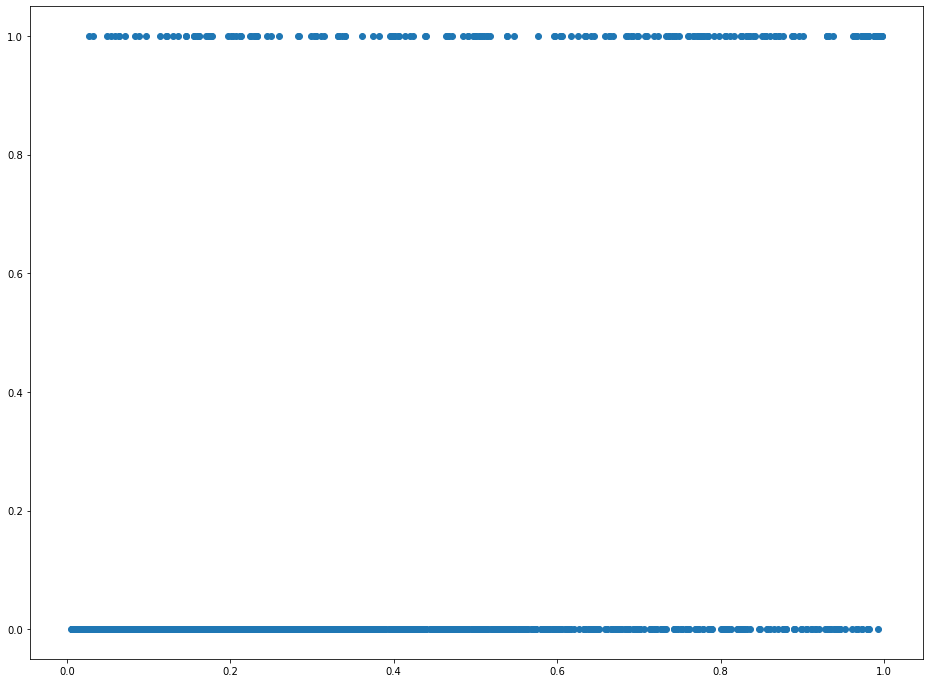

In [22]:
l = -1

metrics_print = metrics_effnetx2

plt.figure(figsize=(16, 12))
plt.scatter(np.array(metrics_print['predict'])[:, l], np.array(metrics_print['label'])[:, l])
# plt.subplot(2, 2, 1)
# plt.scatter(np.array(metrics_print['predict'])[0:1178, l], np.array(metrics_print['label'])[0:1178, l])
# plt.subplot(2, 2, 2)
# plt.scatter(np.array(metrics_print['predict'])[1178:2356, l], np.array(metrics_print['label'])[1178:2356, l])
# plt.subplot(2, 2, 3)
# plt.scatter(np.array(metrics_print['predict'])[2356:3534, l], np.array(metrics_print['label'])[2356:3534, l])
# plt.subplot(2, 2, 4)
# plt.scatter(np.array(metrics_print['predict'])[3534:, l], np.array(metrics_print['label'])[3534:, l])

In [25]:
metric = {'predict': np.array(metrics_convnextx2['predict']), 'label': np.array(metrics_convnextx2['label'])}

weighted_loss = loss_metrics(metric, transform_kls6class)

F1 score:  [0.2162963  0.25474255 0.29711752 0.27884615 0.23678647 0.42190016]
AUC score:  [0.80319995 0.86536138 0.76172625 0.9073029  0.75319336 0.90096823]
